In [2]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Wine dataset with response in {0, 1, 2}, 13 features and 178 samples
X, y = load_wine(return_X_y=True)

In [3]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
# Add a column of ones for the bias term
X_ones = np.c_[np.ones(X.shape[0]), X_normalized]

X_train, X_test, y_train, y_test = train_test_split(X_ones, y, test_size=0.3, random_state=42)

In [5]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905991019/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


## Reparametrization attack

In [6]:
def id(x, y):
    return y

In [7]:
def reparametrization_trick(x_adv, model, G, samples_per_iteration, func):
    # Sample from the model's predictive distribution keeping the gradient flow by using rsample
    y_samples = model.get_predictive_distribution(x_adv.unsqueeze(1)).rsample((samples_per_iteration,))
    
    # Using autograd to compute the gradients
    f_values = func(x_adv, y_samples)
    loss = ((f_values - G) ** 2).mean()
    loss.backward()
    
    return x_adv.grad, f_values.mean(), loss

In [8]:
def true_gradient(x_adv, model, G):
    beta_dot_x = model.mu @ x_adv
    sigma = model.b / model.a
    return 2 * (beta_dot_x + sigma - G) * model.mu

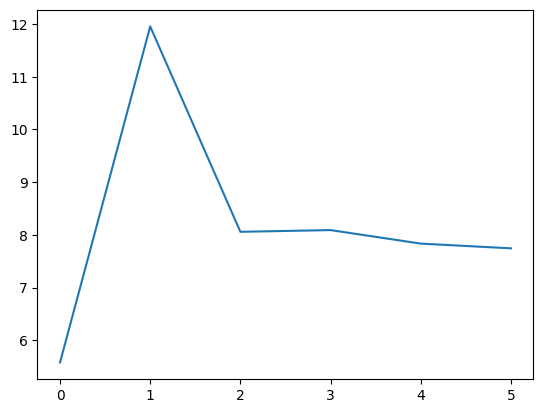

In [16]:
# Vemos como funciona la aproximacion del gradiente segun el numero de samples de reparametrization trick
# TODO: deberia verse como desciende ?????
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
diffs = []
exact_gradient = true_gradient(x_adv, model, 3)
for samples in range(6):
    rep_gradients, _, _ = reparametrization_trick(x_adv, model, 3, 10 ** samples, id)
    diffs.append(torch.norm(rep_gradients - exact_gradient).item())
    x_adv.grad.zero_()

plt.plot(range(6), diffs) 

In [17]:
def attack(x_clean, model, G, samples_per_iteration=10000, learning_rate=1e-1, num_iterations=1000, epsilon=.1, func=id):
    x_0 = x_clean.clone().detach()
    x_adv = x_clean.clone().detach().requires_grad_(True)
    x_adv_values = []
    loss_values = []
    func_values = []

    optimizer = Adam([x_adv], lr=learning_rate)

    for _ in range(num_iterations):
        x_adv.requires_grad = True

        _, f_mean, loss = reparametrization_trick(x_adv, model, G, samples_per_iteration, func=func)

        optimizer.step()
        x_adv.grad.zero_()
        
        with torch.no_grad():
            if torch.norm(x_adv - x_0, p=2) > epsilon:
                x_adv = x_0 + epsilon * (x_adv - x_0) / torch.norm(x_adv - x_0, p=2)
            
        x_adv_values.append(x_adv.clone().detach().numpy())
        loss_values.append(loss.detach().item())
        func_values.append(f_mean.item())

    return x_adv_values, loss_values, func_values

## Attack with mean as objective function

In [24]:
def det_attack(x_clean, model, y_star, epsilon=.1):
    mu = model.mu.numpy()

    beta_dot_x = np.dot(mu, x_adv)
    beta_norm_squared = np.dot(mu, mu)
    x_adv_det = x_adv + ((y_star - beta_dot_x) / beta_norm_squared) * mu

    if np.linalg.norm(np.dot(y_star - beta_dot_x, mu)) > epsilon * beta_norm_squared: 
        print('Optimal perturbation is too large')
        delta_x_adv = epsilon * (np.dot(y_star - beta_dot_x, mu) / (np.linalg.norm(y_star - beta_dot_x) * np.linalg.norm(mu)))
        x_adv_det = x_adv + delta_x_adv

    y_adv_det = np.dot(mu, x_adv_det)
    return x_adv_det, y_adv_det

In [25]:
# Deterministic attack 
x_adv = X_test[17,:].copy()
y_star = 3
epsilon = .3

x_adv_det, y_adv_det = det_attack(x_adv, model, y_star, epsilon)

Optimal perturbation is too large


In [19]:
y_star = 3
epsilon = 2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-2, num_iterations=1000, samples_per_iteration=100)
x_adv_rep = x_adv_values[-1]

Text(0, 0.5, 'Loss')

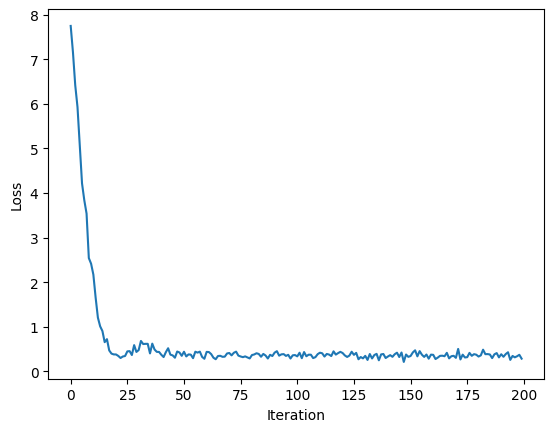

In [20]:
plt.plot(loss_values[:200])
plt.xlabel('Iteration')
plt.ylabel('Loss')

Text(0, 0.5, 'Function value')

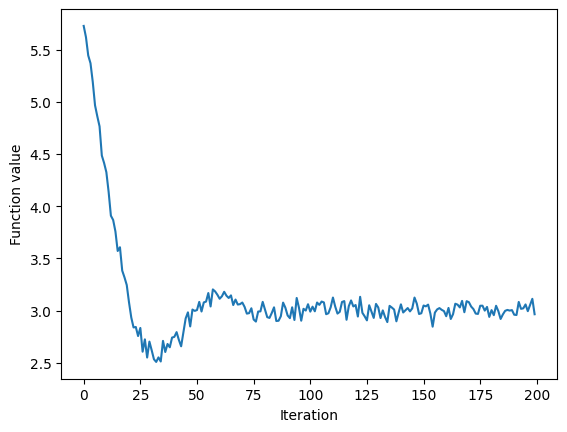

In [21]:
plt.plot(func_values[:200])
plt.xlabel('Iteration')
plt.ylabel('Function value')

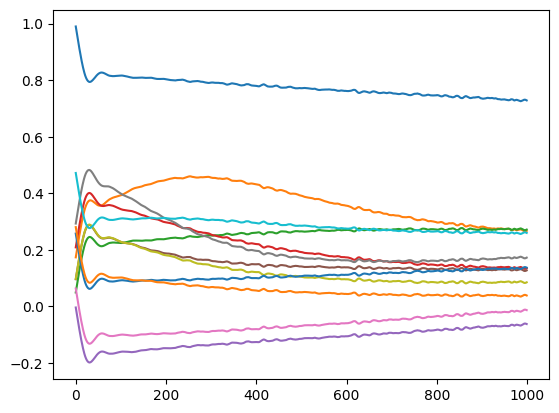

In [22]:
plt.plot(x_adv_values)

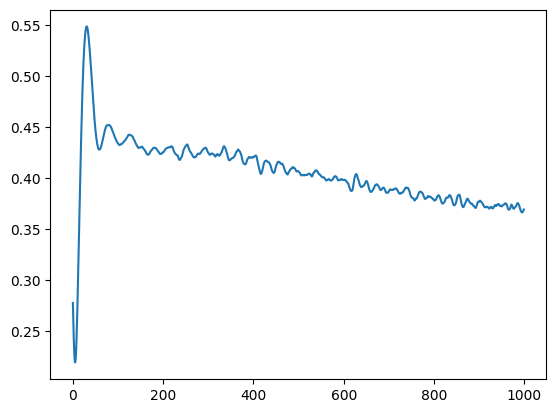

In [23]:
x_diffs = [np.linalg.norm(x - x_adv_det) for x in x_adv_values]
plt.plot(x_diffs)

In [127]:
#table plot of x_adv, x_adv_attacked, X_test[17,:].copy():
import pandas as pd
df = pd.DataFrame(np.c_[x_adv_rep, x_adv_det, X_test[17,:].copy()], columns=['x_adv_reparam', 'x_adv_determ', 'X_test[17,:]'])
df

,x_adv_reparam,x_adv_determ,"X_test[17,:]"
0,1.318481,1.510663,1.000000
1,0.183448,0.170924,0.276316
2,0.533771,0.201727,0.077075
3,0.646847,0.556378,0.614973
4,0.952542,0.984081,0.690722
5,0.312394,0.124677,0.086957
6,0.122333,0.335571,0.351724
7,-0.039852,-0.094843,0.261603
8,0.832076,0.532774,0.509434
9,0.217541,0.324839,0.312303


## Attack with exp(y^2/100) as objective function

In [88]:
y_star = 3
epsilon = .3
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)
def expy2(x, y):
    return torch.exp(y ** 2 / 100)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, learning_rate= 1e-2, samples_per_iteration=1000, num_iterations=10000, epsilon=epsilon, func=expy2)

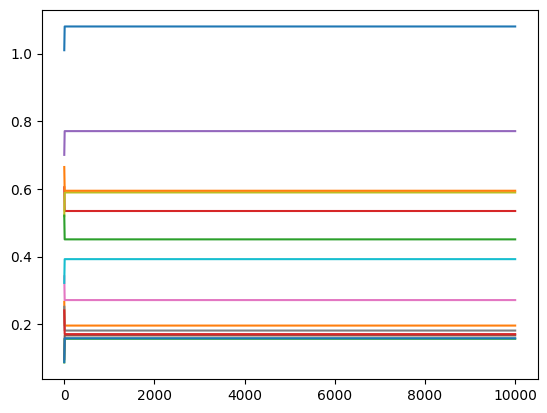

In [92]:
plt.plot(x_adv_values)